In [1]:
import os
import sys
import numpy as np
import pandas as pd
import statsmodels as sm
import matplotlib as plot
import itertools
from tqdm import tqdm
import mdptoolbox

In [15]:
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.7.0
Keras Version: 2.7.0

Python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
Pandas 1.3.4
GPU is NOT AVAILABLE


In [13]:
tf.config.list_physical_devices('GPU')

[]

In [35]:
def convert_to_daily_returns(closing_prices):
    return closing_prices.pct_change()


def convert_to_total_returns(daily_rets):
    return (daily_rets + 1).cumprod() - 1


def calc_mu(daily_rets, center_mass):
    return daily_rets.ewm(com=center_mass).mean().iloc[-1]


def calc_cov(daily_rets, center_mass):
    return daily_rets.ewm(com=center_mass).cov().iloc[-5:]


def calc_markowitz_weights(mu_bar_vec, cov_mat, ret):
    A = np.ones((len(mu_bar_vec))) @ np.linalg.inv(cov_mat) @ mu_bar_vec.T
    B = mu_bar_vec @ np.linalg.inv(cov_mat) @ mu_bar_vec.T
    C = np.ones((len(mu_bar_vec))) @ np.linalg.inv(cov_mat) @ np.ones((len(mu_bar_vec))).T
    D = B*C - A**2
    
    return (B * np.linalg.inv(cov_mat) @ np.ones((len(mu_bar_vec))).T - A * np.linalg.inv(cov_mat) @ mu_bar_vec.T + 
ret * (C * np.linalg.inv(cov_mat) @ mu_bar_vec.T - A * np.linalg.inv(cov_mat) @ np.ones((len(mu_bar_vec))).T)) / D


def get_markowitz_weights(daily_rets, center_mass=60, target_ret=.1/252):
    mu = np.asarray(calc_mu(daily_rets, center_mass))
    cov = np.asarray(calc_cov(daily_rets, center_mass))
    return calc_markowitz_weights(mu, cov, target_ret)


def evaluate_markowitz_portfolio(daily_rets, start_date, end_date, center_mass=60, target_ret=.1/252):
    date_index = daily_rets.loc[start_date:end_date]
    portfolio_rets = pd.DataFrame(index=date_index.index,columns=['Return'])
    
    for date in date_index.index[:-1]:
        weights = get_markowitz_weights(daily_rets.loc[:date])
        idx = np.searchsorted(date_index.index, date)
        portfolio_rets.loc[date_index.index[idx+1], 'Return'] = weights @ np.asarray(daily_rets.loc[date_index.index[idx+1]]).T
        
    return portfolio_rets


def calc_sharpe(rets):
    return (rets.mean()[0] / rets.std()[0]) * np.sqrt(252)

def scale_to_vol(rets, target_vol=.1):
    return rets * (target_vol / rets.std())

def convert_to_discrete_states(daily_rets):
    means = daily_rets.rolling(60).mean()
    temp = means.mask(means > 0, 1)
    return temp.mask(temp < 0, -1)

def get_discrete_states():
    states = dict()
    ind = [1,1,1,1,1]

    states[tuple(ind)] = 0
    index = 1
    for i in range(5):
        temp = ind.copy()
        for j in range(i+1):
            temp[j] = -1
        perms = list(itertools.permutations(temp))
        
        states_set = set()
        for perm in perms:
            states_set.add(perm)
        
        for perm in states_set:
            states[perm] = index
            index += 1
    return states

def get_discrete_actions():
    actions = dict()
    for r in range(10):
        actions[r] = (r+1)*.02
        
    return actions
        
    
def build_transition_matrix(daily_rets_discrete, actions, states):
    
    transition_matrix = np.ones((len(list(states)), len(list(states))))
    
    prior = None
    for r in tqdm(zip(daily_rets_discrete['PFE'], daily_rets_discrete['GE'], daily_rets_discrete['JPM'], daily_rets_discrete['XOM'], daily_rets_discrete['MSFT'])):
        if(prior != None):
            transition_matrix[states[prior]][states[r]] += 1
        prior = r
    
    temp_i = 0
    for row in transition_matrix:
        transition_matrix[temp_i] = row / row.sum()
        temp_i += 1
    
    toReturn = []
    for action in actions.keys():
        toReturn.append(transition_matrix)
        
    return np.asarray(toReturn)


def build_reward_matrix(daily_rets_discrete, daily_rets, actions, states):
    
    toReturn = []
    for action in tqdm(actions.keys()):
        reward_matrix = np.zeros((len(list(states)), len(list(states))))
        reward_counts = np.ones((len(list(states)), len(list(states))))

    
        prior = None
        index = 60
        for r in zip(daily_rets_discrete['PFE'], daily_rets_discrete['GE'], daily_rets_discrete['JPM'], daily_rets_discrete['XOM'], daily_rets_discrete['MSFT']):
            if(prior != None):
                reward_counts[states[prior]][states[r]] += 1
                
                weights = get_markowitz_weights(daily_rets.iloc[:index-1], center_mass=60, target_ret=actions[action]/252)
                ret = weights @ np.asarray(daily_rets.iloc[index])
                
                reward_matrix[states[prior]][states[r]] += ret
            prior = r
            index += 1
    
        toReturn.append(reward_matrix/reward_counts)
        
    return np.asarray(toReturn)

def eval_discrete_policy(daily_rets_discrete, daily_rets, policy, start_date, end_date):
    date_index = daily_rets_discrete.loc[start_date:end_date]
    portfolio_rets = pd.DataFrame(index=date_index.index,columns=['Return'])
    actions_taken = []
    
    for date in date_index.index[:-1]:
        weights = get_markowitz_weights(daily_rets.loc[:date], target_ret=policy[tuple(daily_rets_discrete.loc[date])]/252)
        idx = np.searchsorted(date_index.index, date)
        portfolio_rets.loc[date_index.index[idx+1], 'Return'] = weights @ np.asarray(daily_rets.loc[date_index.index[idx+1]]).T
        actions_taken.append(policy[tuple(daily_rets_discrete.loc[date])])
        
    return portfolio_rets, actions_taken

def eval_actor_policy(daily_rets, state_df, actor_model, start_date, end_date, upper, lower):
    date_index = daily_rets.loc[start_date:end_date]
    portfolio_rets = pd.DataFrame(index=date_index.index,columns=['Return'])
    
    for date in date_index.index[:-1]:
        weights = policy_eval(tf.expand_dims(tf.convert_to_tensor(state_df.loc[date]), 0), actor_model, upper, lower)
        idx = np.searchsorted(date_index.index, date)
        portfolio_rets.loc[date_index.index[idx+1], 'Return'] = (weights @ np.asarray(daily_rets.loc[date_index.index[idx+1]]).T)[0]
        
    return portfolio_rets

In [106]:
tem = pd.read_csv('SP500.csv', index_col='Date', parse_dates=True,thousands=',')
SP500 = pd.DataFrame(tem['Price'].astype(float),index=tem.index)
SP500 = SP500.iloc[::-1]
SP500 = convert_to_daily_returns(SP500)
SP500 = SP500.rename(columns={'Price': 'Return'})

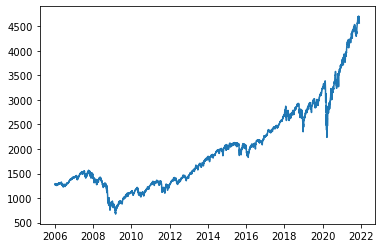

In [107]:
plt.plot(tem['Price'])

<AxesSubplot:xlabel='Date'>

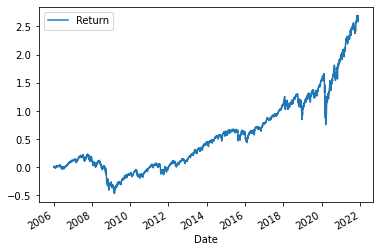

In [108]:
convert_to_total_returns(SP500).plot()

In [3]:
PFE = pd.read_csv('PFE.csv', index_col='Date', parse_dates=True)
GE = pd.read_csv('GE.csv', index_col='Date', parse_dates=True)
JPM = pd.read_csv('JPM.csv', index_col='Date', parse_dates=True)
XOM = pd.read_csv('XOM.csv', index_col='Date', parse_dates=True)
MSFT = pd.read_csv('MSFT.csv', index_col='Date', parse_dates=True)

closing_prices = pd.DataFrame(index=PFE.index, columns=['PFE', 'GE', 'JPM', 'XOM', 'MSFT'])
closing_prices['PFE'] = PFE['Close']
closing_prices['GE'] = GE['Close']
closing_prices['JPM'] = JPM['Close']
closing_prices['XOM'] = XOM['Close']
closing_prices['MSFT'] = MSFT['Close']

daily_rets = convert_to_daily_returns(closing_prices)
total_returns = convert_to_total_returns(daily_rets)

In [39]:
transitions = build_transition_matrix(daily_rets_discrete.loc[:'12-31-2015'], discrete_actions, discrete_states)
rewards = build_reward_matrix(daily_rets_discrete.loc[:'12-31-2015'], daily_rets.loc[:'12-31-2015'], discrete_actions, discrete_states)

6278it [00:00, 465580.57it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████| 10/10 [17:25<00:00, 104.52s/it]


In [37]:
daily_rets_discrete = convert_to_discrete_states(daily_rets).iloc[60:]
discrete_states = get_discrete_states()
discrete_actions = get_discrete_actions()

In [41]:
Q_Learning = mdptoolbox.mdp.QLearning(transitions, rewards, 1, n_iter=1000000)
Q_Learning.run()

Q_Learning.policy
opt_policy = dict()
for state in discrete_states:
    opt_policy[state] = Q_Learning.policy[discrete_states[state]]

In [ ]:
q_rets_2008 = scale_to_vol(eval_discrete_policy(daily_rets_discrete, daily_rets, opt_policy,  "2008", "2008-12-31"))
total_q_rets_2008 = convert_to_total_returns(q_rets_2008)

q_rets_1995, actions_1995 = eval_discrete_policy(daily_rets_discrete, daily_rets, opt_policy,  "1995", "1995-12-31")
q_rets_1995 = scale_to_vol(q_rets_1995)
total_q_rets_1995 = convert_to_total_returns(q_rets_1995)

q_rets_2020, actions_2020 = eval_discrete_policy(daily_rets_discrete, daily_rets, opt_policy,  "2020", "2020-12-31")
q_rets_2020 = scale_to_vol(q_rets_2020)
total_q_rets_2020 = convert_to_total_returns(q_rets_2020)

In [ ]:
q_rets_full, actions_full = eval_discrete_policy(daily_rets_discrete, daily_rets, opt_policy,  "1996", "2020-12-31")
q_rets_full = scale_to_vol(q_rets_full)
total_q_rets_full = convert_to_total_returns(q_rets_full)

In [ ]:
markowitz_rets_2008 = evaluate_markowitz_portfolio(daily_rets, "2008", "2008-12-31")
markowitz_rets_2020 = evaluate_markowitz_portfolio(daily_rets, "2020", "2020-12-31")
markowitz_rets_1995 = evaluate_markowitz_portfolio(daily_rets, "1995", "1995-12-31")
markowitz_rets_full = evaluate_markowitz_portfolio(daily_rets, "1995", "2021-12-31")

In [ ]:
markowitz_rets_2008 = scale_to_vol(markowitz_rets_2008)
markowitz_rets_2020 = scale_to_vol(markowitz_rets_2020)
markowitz_rets_1995 = scale_to_vol(markowitz_rets_1995)
markowitz_rets_full = scale_to_vol(markowitz_rets_full)

In [ ]:
total_markowitz_rets_2008 = convert_to_total_returns(markowitz_rets_2008)
total_markowitz_rets_2020 = convert_to_total_returns(markowitz_rets_2020)
total_markowitz_rets_1995 = convert_to_total_returns(markowitz_rets_1995)
total_markowitz_rets_full = convert_to_total_returns(markowitz_rets_full)

In [ ]:
print("2008 Sharpe: " , calc_sharpe(markowitz_rets_2008))
total_markowitz_rets_2008.plot(figsize=(10,10))

print("2020 Sharpe: " , calc_sharpe(markowitz_rets_2020))
total_markowitz_rets_2020.plot(figsize=(10,10))

print("1995 Sharpe: " , calc_sharpe(markowitz_rets_1995))
total_markowitz_rets_1995.plot(figsize=(10,10))

print("1995-Present Sharpe: " , calc_sharpe(markowitz_rets_full))
total_markowitz_rets_full.plot(figsize=(10,10))

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [5]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [6]:
class Buffer:
    def __init__(self, num_states, num_actions, actor_model, critic_model, target_actor, target_critic, actor_optimizer, critic_optimizer, gamma, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
        self.num_states = num_states
        self.num_actions = num_actions
        
        self.actor_model = actor_model
        self.critic_model = critic_model
        
        self.target_actor = target_actor
        self.target_critic = target_critic
        
        self.actor_optimizer = actor_optimizer
        self.critic_optimizer = critic_optimizer
        
        self.gamma = gamma

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch, training=True)
            y = reward_batch + self.gamma * self.target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = self.critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
        self.critic_optimizer.apply_gradients(
            zip(critic_grad, self.critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = self.actor_model(state_batch, training=True)
            critic_value = self.critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        self.actor_optimizer.apply_gradients(
            zip(actor_grad, self.actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [26]:
def get_actor(num_states, upper_bound):
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(5, activation="tanh", kernel_initializer=last_init)(out)

    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic(num_states, num_actions):
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(256, activation="relu")(state_input)
    state_out = layers.Dense(256, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(5, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)

    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

def policy(state, noise_object, actor_model, upper_bound, lower_bound):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)
    return [np.squeeze(legal_action)]

def policy_eval(state, actor_model, upper_bound, lower_bound):
    sampled_actions = tf.squeeze(actor_model(state))
    sampled_actions = sampled_actions.numpy()

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)
    return [np.squeeze(legal_action)]

def build_actor_critic_model(state_df, upper_bound, lower_bound, start_date, end_date, num_actions):

    num_states = len(state_df.columns)

    std_dev = 0.1
    ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

    actor_model = get_actor(num_states, upper_bound)
    critic_model = get_critic(num_states, num_actions)

    target_actor = get_actor(num_states, upper_bound)
    target_critic = get_critic(num_states, num_actions)

    # Making the weights equal initially
    target_actor.set_weights(actor_model.get_weights())
    target_critic.set_weights(critic_model.get_weights())

    # Learning rate for actor-critic models
    critic_lr = 0.02
    actor_lr = 0.01

    critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
    actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

    total_episodes = 100
    # Discount factor for future rewards
    gamma = 1.00
    # Used to update target networks
    tau = 0.05

    buffer = Buffer(num_states, num_actions, actor_model, critic_model, target_actor, target_critic, actor_optimizer, critic_optimizer, gamma, 50000, 64)
    
    # To store reward history of each episode
    ep_reward_list = []
    # To store average reward history of last few episodes
    avg_reward_list = []

    for ep in range(total_episodes):

        prev_state = np.asarray((state_df.loc[start_date:end_date]).iloc[0])
        episodic_reward = 1
        date_index = (state_df.loc[start_date:end_date]).iloc[1:].index

        for date in date_index:

            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

            action = policy(tf_prev_state, ou_noise, actor_model, upper_bound, lower_bound)

            state = state_df.loc[date]
            reward = daily_rets.loc[date] @ np.asarray(action[0])

            buffer.record((prev_state, np.asarray(action[0]), reward, state))
            episodic_reward *= (reward + 1)
            #episodic_reward += (reward)


            buffer.learn()
            update_target(target_actor.variables, actor_model.variables, tau)
            update_target(target_critic.variables, critic_model.variables, tau)

            prev_state = state

        ep_reward_list.append(episodic_reward)

        # Mean of last 40 episodes
        avg_reward = np.mean(ep_reward_list)
        print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
        print("Episode * {} * Reward is ==> {}".format(ep, ep_reward_list[-1]))
        avg_reward_list.append(avg_reward)
        
    plt.plot(ep_reward_list)
    return actor_model, critic_model

    

In [27]:
rolling_mu = daily_rets.ewm(com=60).mean()
rolling_mu.dropna(inplace=True)
rolling_cov = daily_rets.ewm(com=60).cov()
rolling_cov.dropna(inplace=True)

In [28]:
state_df = pd.DataFrame(index=daily_rets.index[2:], columns=[i for i in range(30)],dtype=float)
for date in state_df.index:
    cov = rolling_cov.loc[date]
    mu = rolling_mu.loc[date]
    state = np.concatenate([np.asarray(mu),np.asarray(cov).flatten()])
    state_df.loc[date] = state

Episode * 0 * Avg Reward is ==> 4.319082260942504
Episode * 0 * Reward is ==> 4.319082260942504
Episode * 1 * Avg Reward is ==> 4.197680596985327
Episode * 1 * Reward is ==> 4.076278933028149
Episode * 2 * Avg Reward is ==> 13.291020575254477
Episode * 2 * Reward is ==> 31.477700531792774
Episode * 3 * Avg Reward is ==> 10.775912768662696
Episode * 3 * Reward is ==> 3.2305893488873583
Episode * 4 * Avg Reward is ==> 9.024386970041414
Episode * 4 * Reward is ==> 2.0182837755562826
Episode * 5 * Avg Reward is ==> 8.947749079684433
Episode * 5 * Reward is ==> 8.564559627899532
Episode * 6 * Avg Reward is ==> 8.108132886118593
Episode * 6 * Reward is ==> 3.070435724723551
Episode * 7 * Avg Reward is ==> 7.603066161326083
Episode * 7 * Reward is ==> 4.067599087778512
Episode * 8 * Avg Reward is ==> 7.4709608778152115
Episode * 8 * Reward is ==> 6.414118609728237
Episode * 9 * Avg Reward is ==> 7.010579560355228
Episode * 9 * Reward is ==> 2.8671477032153785
Episode * 10 * Avg Reward is ==> 

Episode * 84 * Avg Reward is ==> 5.821565712620972
Episode * 84 * Reward is ==> 2.746164502334227
Episode * 85 * Avg Reward is ==> 5.871720825111729
Episode * 85 * Reward is ==> 10.134905386826127
Episode * 86 * Avg Reward is ==> 5.8511236147205485
Episode * 86 * Reward is ==> 4.079763521079025
Episode * 87 * Avg Reward is ==> 5.838026771719609
Episode * 87 * Reward is ==> 4.698601430637966
Episode * 88 * Avg Reward is ==> 5.79591682366549
Episode * 88 * Reward is ==> 2.090241394902939
Episode * 89 * Avg Reward is ==> 5.7937949893001495
Episode * 89 * Reward is ==> 5.604951730784962
Episode * 90 * Avg Reward is ==> 5.752996857332502
Episode * 90 * Reward is ==> 2.0811649802442496
Episode * 91 * Avg Reward is ==> 5.769514432754167
Episode * 91 * Reward is ==> 7.272613796125568
Episode * 92 * Avg Reward is ==> 5.909671357480969
Episode * 92 * Reward is ==> 18.80410843234676
Episode * 93 * Avg Reward is ==> 5.895120440876293
Episode * 93 * Reward is ==> 4.5418851966414815
Episode * 94 * A

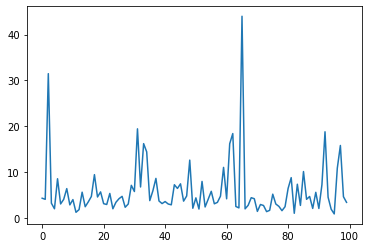

In [29]:
with tf.device("gpu:0"):
    actor, critic = build_actor_critic_model(state_df.dropna(), 1.0, -1.0, '1995', '12-31-2015', 5)

In [33]:
actor_rets = eval_actor_policy(daily_rets, state_df, actor, '2016', '12-31-2016', 1.0, -1.0)
actor_rets1 = eval_actor_policy(daily_rets, state_df, actor, '2017', '12-31-2017', 1.0, -1.0)
actor_rets2 = eval_actor_policy(daily_rets, state_df, actor, '2018', '12-31-2018', 1.0, -1.0)
actor_rets3 = eval_actor_policy(daily_rets, state_df, actor, '2019', '12-31-2019', 1.0, -1.0)
actor_rets4 = eval_actor_policy(daily_rets, state_df, actor, '2020', '12-31-2020', 1.0, -1.0)

Q-Learning Sharpe:  -0.5043733251195015
DDPG Sharpe:  0.7008759550206275
Markowitz Sharpe:  1.2726177135455021
S&P500 Sharpe:  0.7609500796065236


<AxesSubplot:title={'center':'Total Cumulative Return'}, xlabel='Date'>

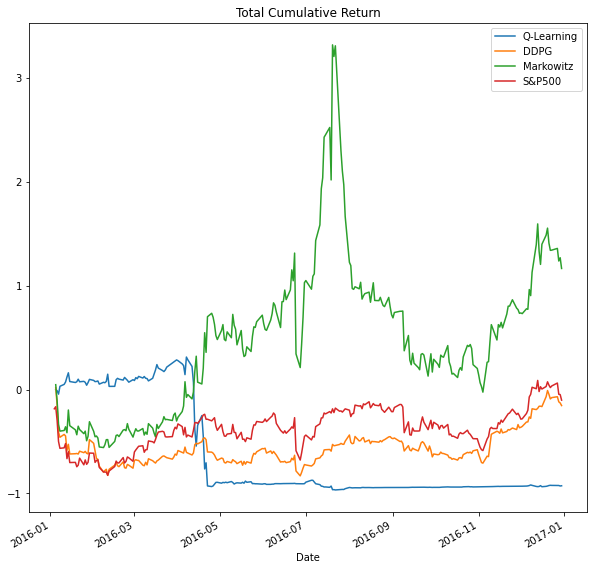

In [109]:
start = '2016'
end = "2016-12-31"

mdp_ret, _ = eval_discrete_policy(daily_rets_discrete, daily_rets, opt_policy,  start, end)
temp = convert_to_total_returns(scale_to_vol(mdp_ret.loc[start:end]))
temp2 = convert_to_total_returns(scale_to_vol(actor_rets.loc[start:end]))
temp3 = evaluate_markowitz_portfolio(daily_rets, start, end)

print('Q-Learning Sharpe: ', calc_sharpe(mdp_ret.loc[start:end]))
print('DDPG Sharpe: ', calc_sharpe(actor_rets.loc[start:end]))
print('Markowitz Sharpe: ', calc_sharpe(temp3.loc[start:end]))
print('S&P500 Sharpe: ', calc_sharpe(SP500.loc[start:end]))



temp['DDPG'] = temp2['Return']
temp = temp.rename(columns={'Return': 'Q-Learning'})
temp['Markowitz'] = convert_to_total_returns(scale_to_vol(temp3.loc[start:end]))['Return']
temp['S&P500'] = convert_to_total_returns(scale_to_vol(SP500.loc[start:end]))
temp.plot(figsize=(10,10), title='Total Cumulative Return')

Q-Learning Sharpe:  2.0691601805849236
DDPG Sharpe:  0.3931336188023946
Markowitz Sharpe:  0.8088821674620632
S&P500 Sharpe:  2.6994135285240586


<AxesSubplot:title={'center':'Total Cumulative Return'}, xlabel='Date'>

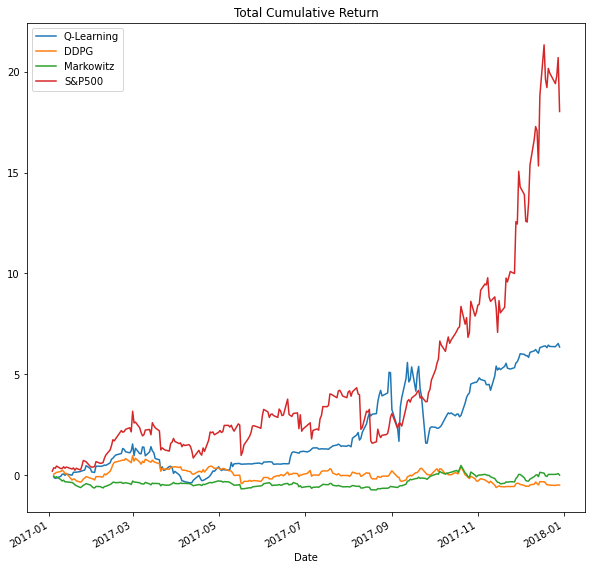

In [115]:
start = '2017'
end = "2017-12-31"

mdp_ret, _ = eval_discrete_policy(daily_rets_discrete, daily_rets, opt_policy,  start, end)
temp = convert_to_total_returns(scale_to_vol(mdp_ret.loc[start:end]))
temp2 = convert_to_total_returns(scale_to_vol(actor_rets1.loc[start:end]))
temp3 = evaluate_markowitz_portfolio(daily_rets, start, end)

print('Q-Learning Sharpe: ', calc_sharpe(mdp_ret.loc[start:end]))
print('DDPG Sharpe: ', calc_sharpe(actor_rets1.loc[start:end]))
print('Markowitz Sharpe: ', calc_sharpe(temp3.loc[start:end]))
print('S&P500 Sharpe: ', calc_sharpe(SP500.loc[start:end]))



temp['DDPG'] = temp2['Return']
temp = temp.rename(columns={'Return': 'Q-Learning'})
temp['Markowitz'] = convert_to_total_returns(scale_to_vol(temp3.loc[start:end]))['Return']
temp['S&P500'] = convert_to_total_returns(scale_to_vol(SP500.loc[start:end]))
temp.plot(figsize=(10,10), title='Total Cumulative Return')

Q-Learning Sharpe:  1.8405453798185576
DDPG Sharpe:  -0.36512948485662333
Markowitz Sharpe:  0.052940671003408116
S&P500 Sharpe:  -0.29392841023302435


<AxesSubplot:title={'center':'Total Cumulative Return'}, xlabel='Date'>

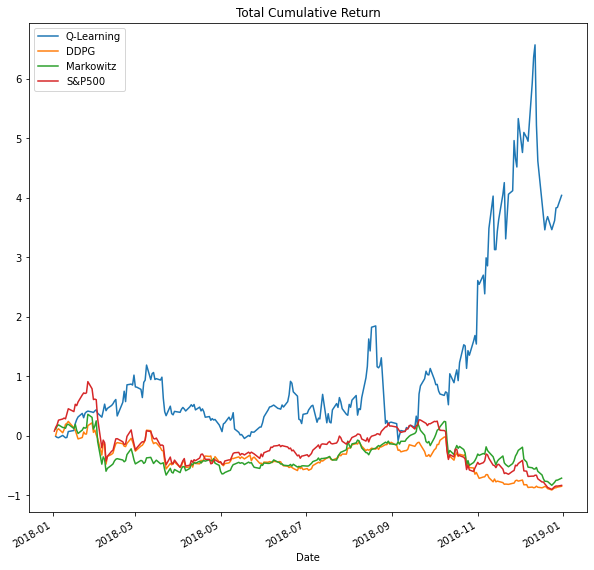

In [111]:
start = '2018'
end = "2018-12-31"

mdp_ret, _ = eval_discrete_policy(daily_rets_discrete, daily_rets, opt_policy,  start, end)
temp = convert_to_total_returns(scale_to_vol(mdp_ret.loc[start:end]))
temp2 = convert_to_total_returns(scale_to_vol(actor_rets2.loc[start:end]))
temp3 = evaluate_markowitz_portfolio(daily_rets, start, end)

print('Q-Learning Sharpe: ', calc_sharpe(mdp_ret.loc[start:end]))
print('DDPG Sharpe: ', calc_sharpe(actor_rets2.loc[start:end]))
print('Markowitz Sharpe: ', calc_sharpe(temp3.loc[start:end]))
print('S&P500 Sharpe: ', calc_sharpe(SP500.loc[start:end]))



temp['DDPG'] = temp2['Return']
temp = temp.rename(columns={'Return': 'Q-Learning'})
temp['Markowitz'] = convert_to_total_returns(scale_to_vol(temp3.loc[start:end]))['Return']
temp['S&P500'] = convert_to_total_returns(scale_to_vol(SP500.loc[start:end]))
temp.plot(figsize=(10,10), title='Total Cumulative Return')

Q-Learning Sharpe:  -0.3454369970980173
DDPG Sharpe:  1.9281417308893216
Markowitz Sharpe:  -0.08819600547414617
S&P500 Sharpe:  2.0986504354614923


<AxesSubplot:title={'center':'Total Cumulative Return'}, xlabel='Date'>

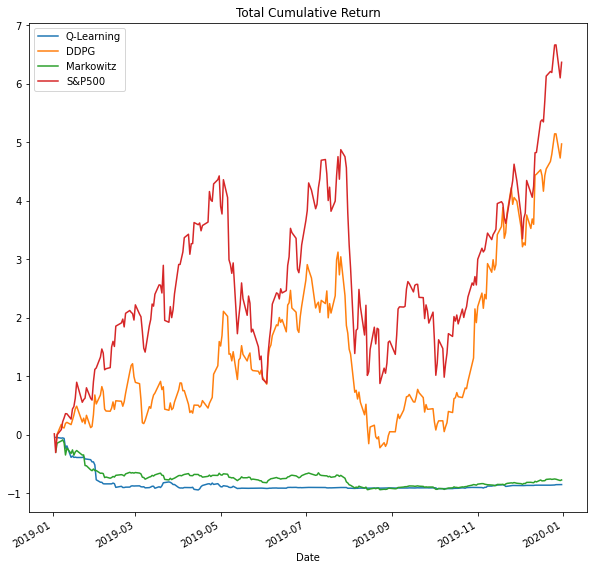

In [112]:
start = '2019'
end = "2019-12-31"

mdp_ret, _ = eval_discrete_policy(daily_rets_discrete, daily_rets, opt_policy,  start, end)
temp = convert_to_total_returns(scale_to_vol(mdp_ret.loc[start:end]))
temp2 = convert_to_total_returns(scale_to_vol(actor_rets3.loc[start:end]))
temp3 = evaluate_markowitz_portfolio(daily_rets, start, end)

print('Q-Learning Sharpe: ', calc_sharpe(mdp_ret.loc[start:end]))
print('DDPG Sharpe: ', calc_sharpe(actor_rets3.loc[start:end]))
print('Markowitz Sharpe: ', calc_sharpe(temp3.loc[start:end]))
print('S&P500 Sharpe: ', calc_sharpe(SP500.loc[start:end]))



temp['DDPG'] = temp2['Return']
temp = temp.rename(columns={'Return': 'Q-Learning'})
temp['Markowitz'] = convert_to_total_returns(scale_to_vol(temp3.loc[start:end]))['Return']
temp['S&P500'] = convert_to_total_returns(scale_to_vol(SP500.loc[start:end]))
temp.plot(figsize=(10,10), title='Total Cumulative Return')

Q-Learning Sharpe:  1.2685470007202473
DDPG Sharpe:  0.8023732175402389
Markowitz Sharpe:  0.555409611272615
S&P500 Sharpe:  0.6090589480654938


<AxesSubplot:title={'center':'Total Cumulative Return'}, xlabel='Date'>

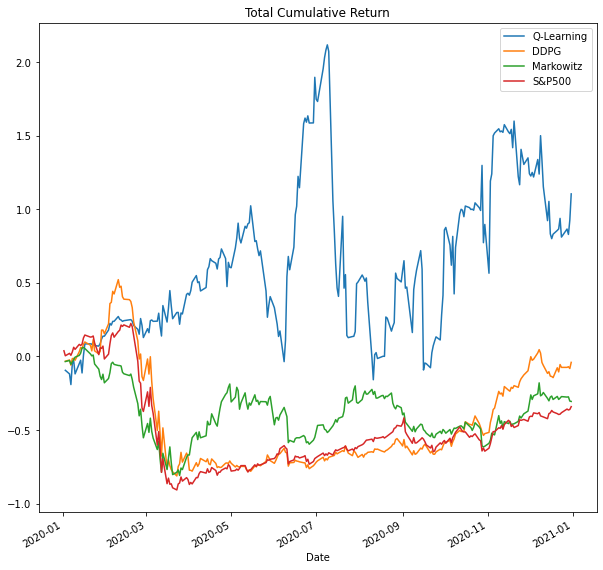

In [113]:
start = '2020'
end = "2020-12-31"

mdp_ret, _ = eval_discrete_policy(daily_rets_discrete, daily_rets, opt_policy,  start, end)
temp = convert_to_total_returns(scale_to_vol(mdp_ret.loc[start:end]))
temp2 = convert_to_total_returns(scale_to_vol(actor_rets4.loc[start:end]))
temp3 = evaluate_markowitz_portfolio(daily_rets, start, end)

print('Q-Learning Sharpe: ', calc_sharpe(mdp_ret.loc[start:end]))
print('DDPG Sharpe: ', calc_sharpe(actor_rets4.loc[start:end]))
print('Markowitz Sharpe: ', calc_sharpe(temp3.loc[start:end]))
print('S&P500 Sharpe: ', calc_sharpe(SP500.loc[start:end]))



temp['DDPG'] = temp2['Return']
temp = temp.rename(columns={'Return': 'Q-Learning'})
temp['Markowitz'] = convert_to_total_returns(scale_to_vol(temp3.loc[start:end]))['Return']
temp['S&P500'] = convert_to_total_returns(scale_to_vol(SP500.loc[start:end]))
temp.plot(figsize=(10,10), title='Total Cumulative Return')

Q-Learning Sharpe:  0.5862176586490719
DDPG Sharpe:  0.6926645580068044
Markowitz Sharpe:  0.4628966881887658
S&P500 Sharpe:  0.7302421219675714


<AxesSubplot:title={'center':'Total Cumulative Return'}, xlabel='Date'>

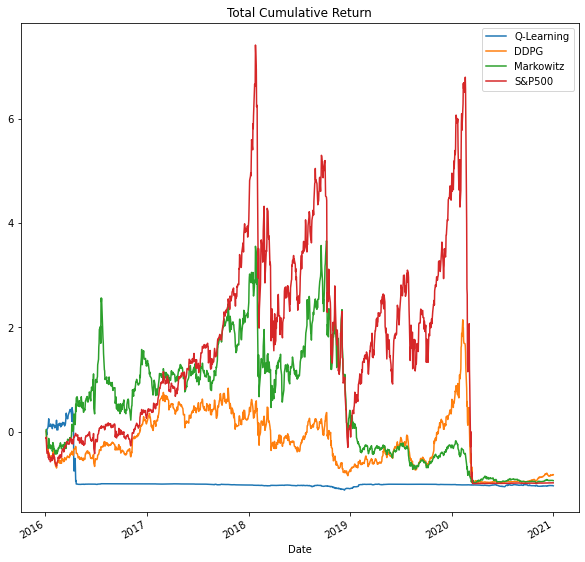

In [114]:
actor_rets5 = eval_actor_policy(daily_rets, state_df, actor, '2016', '12-31-2020', 1.0, -1.0)

start = '2016'
end = "2020-12-31"

mdp_ret, _ = eval_discrete_policy(daily_rets_discrete, daily_rets, opt_policy,  start, end)
temp = convert_to_total_returns(scale_to_vol(mdp_ret.loc[start:end]))
temp2 = convert_to_total_returns(scale_to_vol(actor_rets5.loc[start:end]))
temp3 = evaluate_markowitz_portfolio(daily_rets, start, end)

print('Q-Learning Sharpe: ', calc_sharpe(mdp_ret.loc[start:end]))
print('DDPG Sharpe: ', calc_sharpe(actor_rets5.loc[start:end]))
print('Markowitz Sharpe: ', calc_sharpe(temp3.loc[start:end]))
print('S&P500 Sharpe: ', calc_sharpe(SP500.loc[start:end]))



temp['DDPG'] = temp2['Return']
temp = temp.rename(columns={'Return': 'Q-Learning'})
temp['Markowitz'] = convert_to_total_returns(scale_to_vol(temp3.loc[start:end]))['Return']
temp['S&P500'] = convert_to_total_returns(scale_to_vol(SP500.loc[start:end]))
temp.plot(figsize=(10,10), title='Total Cumulative Return')

In [ ]:
# Save the weights
actor_model.save_weights("pendulum_actor.h5")
critic_model.save_weights("pendulum_critic.h5")

target_actor.save_weights("pendulum_target_actor.h5")
target_critic.save_weights("pendulum_target_critic.h5")